In [2]:
# importing the necessary libraries.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, precision_score,recall_score,f1_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve,precision_recall_curve,auc,make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

In [3]:
# get the data and save it in a dataframe.
df= pd.read_csv("MicroCreditDefault_Data file.csv")
df.head()

,Unnamed: 0,label,msisdn,aon,daily_decr30,daily_decr90,rental30,rental90,last_rech_date_ma,last_rech_date_da,...,maxamnt_loans30,medianamnt_loans30,cnt_loans90,amnt_loans90,maxamnt_loans90,medianamnt_loans90,payback30,payback90,pcircle,pdate
0,1,0,21408I70789,272.0,3055.050000,3065.150000,220.13,260.13,2.0,0.0,...,6.0,0.0,2.0,12,6,0.0,29.000000,29.000000,UPW,2016-07-20
1,2,1,76462I70374,712.0,12122.000000,12124.750000,3691.26,3691.26,20.0,0.0,...,12.0,0.0,1.0,12,12,0.0,0.000000,0.000000,UPW,2016-08-10
2,3,1,17943I70372,535.0,1398.000000,1398.000000,900.13,900.13,3.0,0.0,...,6.0,0.0,1.0,6,6,0.0,0.000000,0.000000,UPW,2016-08-19
3,4,1,55773I70781,241.0,21.228000,21.228000,159.42,159.42,41.0,0.0,...,6.0,0.0,2.0,12,6,0.0,0.000000,0.000000,UPW,2016-06-06
4,5,1,03813I82730,947.0,150.619333,150.619333,1098.90,1098.90,4.0,0.0,...,6.0,0.0,7.0,42,6,0.0,2.333333,2.333333,UPW,2016-06-22


In [4]:
df.shape

(209593, 37)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209593 entries, 0 to 209592
Data columns (total 37 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            209593 non-null  int64  
 1   label                 209593 non-null  int64  
 2   msisdn                209593 non-null  object 
 3   aon                   209593 non-null  float64
 4   daily_decr30          209593 non-null  float64
 5   daily_decr90          209593 non-null  float64
 6   rental30              209593 non-null  float64
 7   rental90              209593 non-null  float64
 8   last_rech_date_ma     209593 non-null  float64
 9   last_rech_date_da     209593 non-null  float64
 10  last_rech_amt_ma      209593 non-null  int64  
 11  cnt_ma_rech30         209593 non-null  int64  
 12  fr_ma_rech30          209593 non-null  float64
 13  sumamnt_ma_rech30     209593 non-null  float64
 14  medianamnt_ma_rech30  209593 non-null  float64
 15  

In [6]:
df.isnull().sum().sum()

0

In [7]:
df.drop(columns=['Unnamed: 0','msisdn'],inplace=True)

In [8]:
df['pcircle'].value_counts()

UPW    209593
Name: pcircle, dtype: int64

In [9]:
df.drop('pcircle',axis=1,inplace=True)

In [10]:
df.duplicated().value_counts()

False    209562
True         31
dtype: int64

In [11]:
df.drop_duplicates(inplace=True,ignore_index=True)

In [12]:
df['pdate']= pd.to_datetime(df['pdate'],format='%Y-%m-%d',dayfirst=True)
df['day']= df['pdate'].dt.day
df['month']= df['pdate'].dt.month
df['year']= df['pdate'].dt.year
df.drop(columns=['pdate'],inplace=True)

In [13]:
df['year'].unique()

array([2016], dtype=int64)

In [14]:
df.drop('year',axis=1,inplace=True)

In [15]:
# Segregating of continuous and categorical columns.
cont_features=[]
cat_features=[]
for i in df.columns:
    if df[i].dtype=='O':
        if len(df[i].unique())<=25:
            cat_features.append(i)
        else:
            cont_features.append(i)
    elif df[i].dtype=='int64':
        if len(df[i].unique())<=25:
            cat_features.append(i)
        else:
            cont_features.append(i)
    elif df[i].dtype=='float64':
        if len(df[i].unique())<=25:
            cat_features.append(i)
        else:
            cont_features.append(i)
    else:
        print(i)

In [16]:
cat_features

['label',
 'medianamnt_loans30',
 'maxamnt_loans90',
 'medianamnt_loans90',
 'month']

In [17]:
cont_features.pop()
cat_features.append('day')
cat_features.remove('label')
cat_features

['medianamnt_loans30', 'maxamnt_loans90', 'medianamnt_loans90', 'month', 'day']

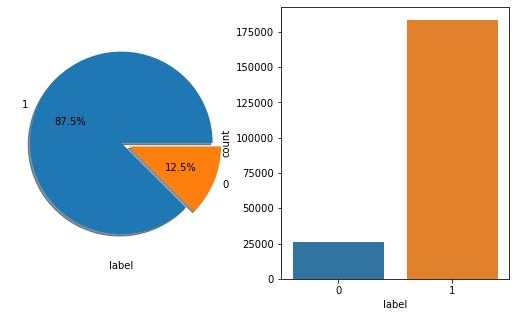

In [18]:
# Plot of target variable i.e. 'label'.
f,ax=plt.subplots(1,2,figsize=(9,5))
df['label'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_ylabel('')
ax[0].set_xlabel('label')
sns.countplot(df['label'],ax=ax[1])
plt.show()

# The target column is highly imbalanced.

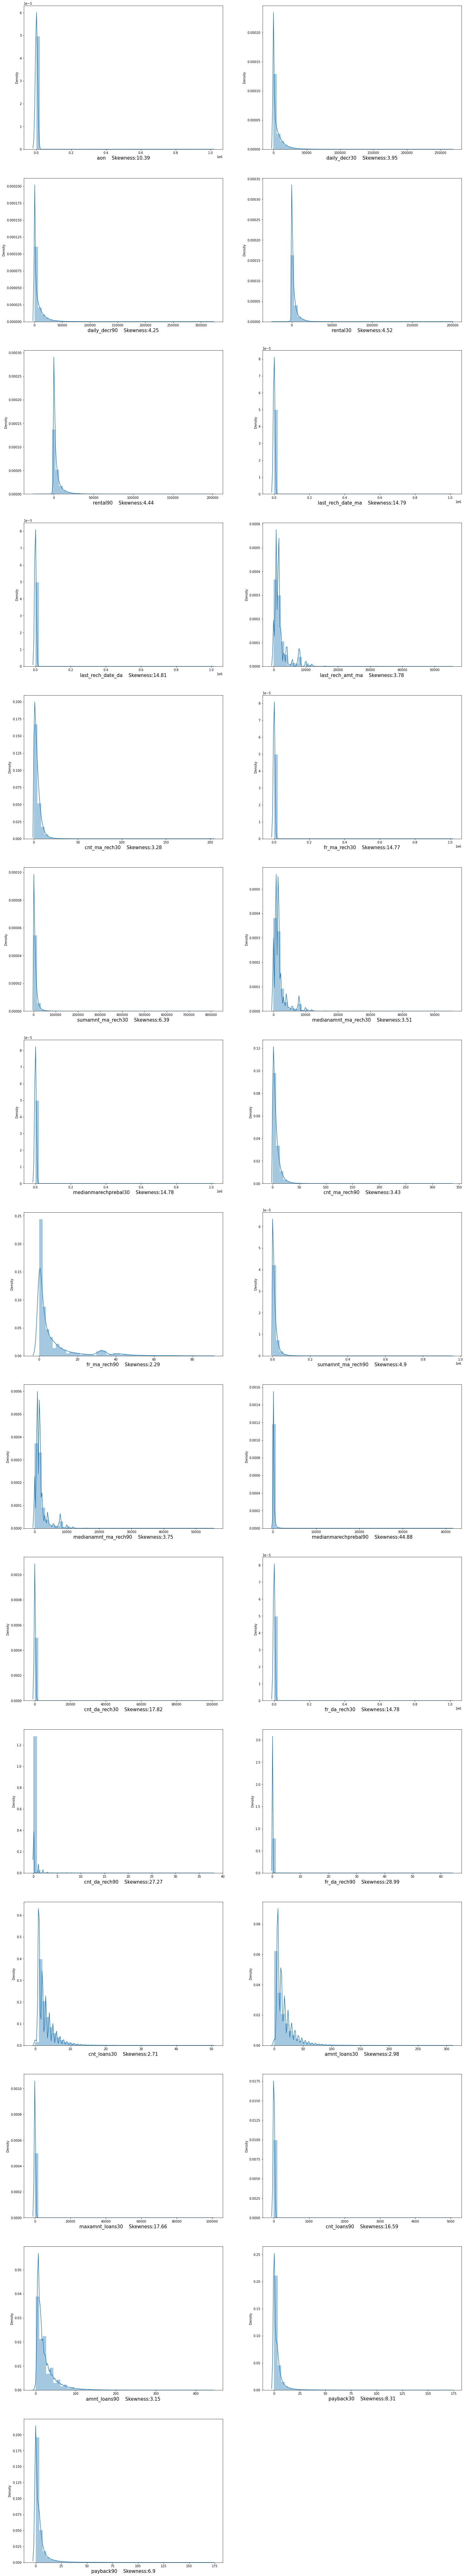

In [19]:
# Distribution plots of the columns with continuous data.
plt.figure(figsize=(25,150))
plotnumber=1
for column in cont_features:
    if plotnumber<=30:
        ax= plt.subplot(15,2,plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column+'    '+'Skewness:'+str(round(df[column].skew(),2)),fontsize=15)
    plotnumber+=1
plt.show()

# Observations:
# All of them have highly right-skewed data.

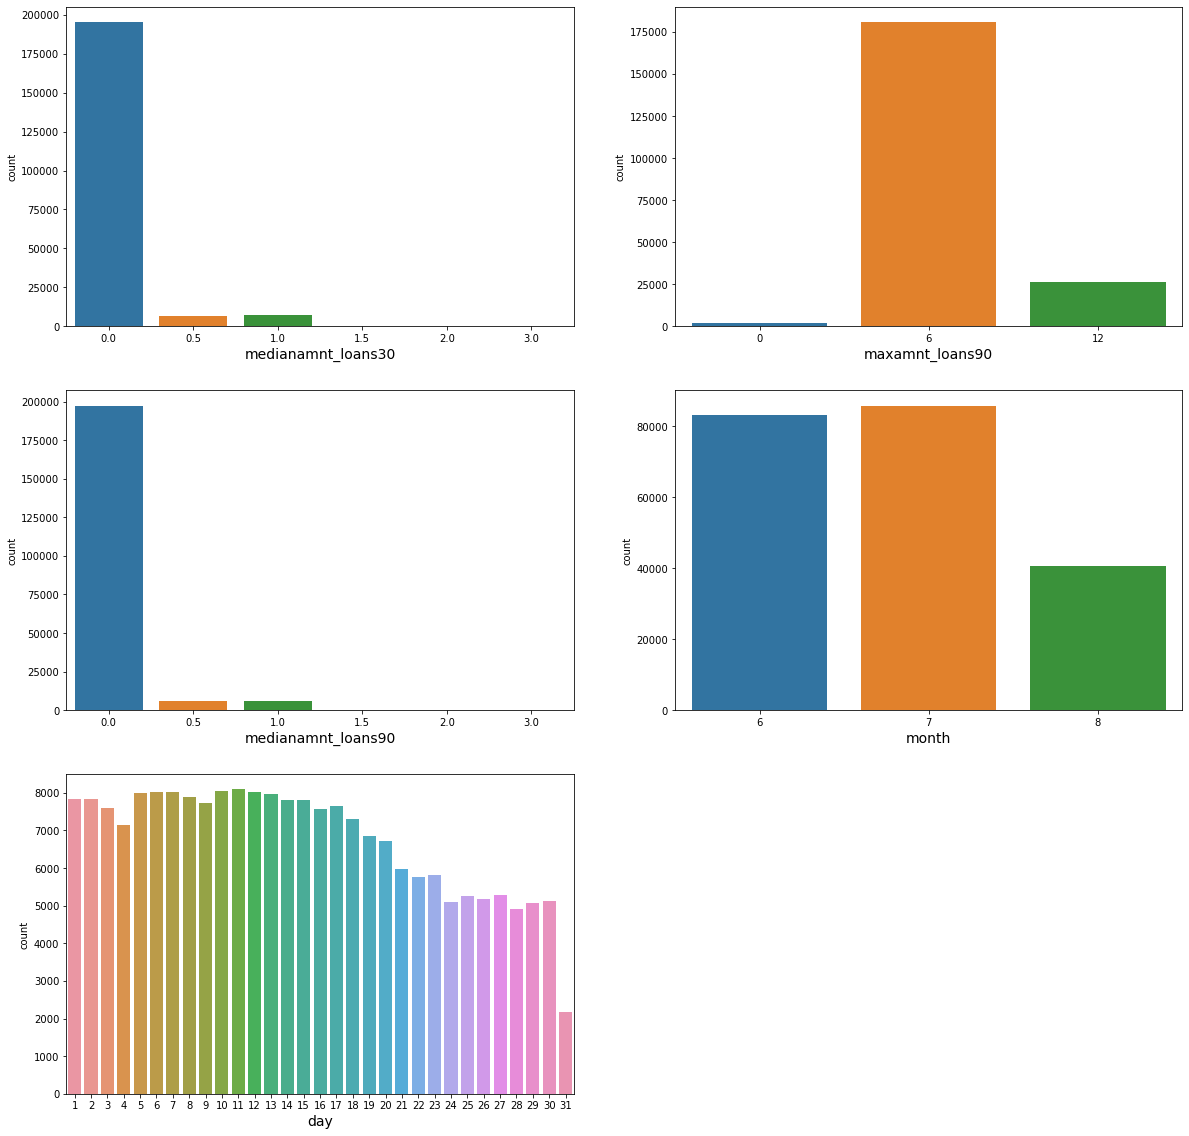

In [20]:
# Count plots of the columns with categorical data.
plt.figure(figsize=(20,20))
plotnumber=1
for column in cat_features:
    if plotnumber<=6:
        ax= plt.subplot(3,2,plotnumber)
        sns.countplot(df[column])
        plt.xlabel(column,fontsize=14)
        if column in ['umbrella_limit','insured_occupation','insured_hobbies','auto_make','auto_model']:
            plt.xticks(rotation=45)
    plotnumber+=1
plt.show()

# Observations:
# 1. More than 80% customers have 6(in Indonesian Rupiah) as 'maxamnt_loans90'(maximum amount of loan taken by the user in last 
#    90 days)
# 2. More than 85% customers have 0 as 'medianamnt_loans30'(Number of loans taken by user in last 30 days).
# 3. More than 85% customers have 0 as 'medianamnt_loans90'(Number of loans taken by user in last 90 days).

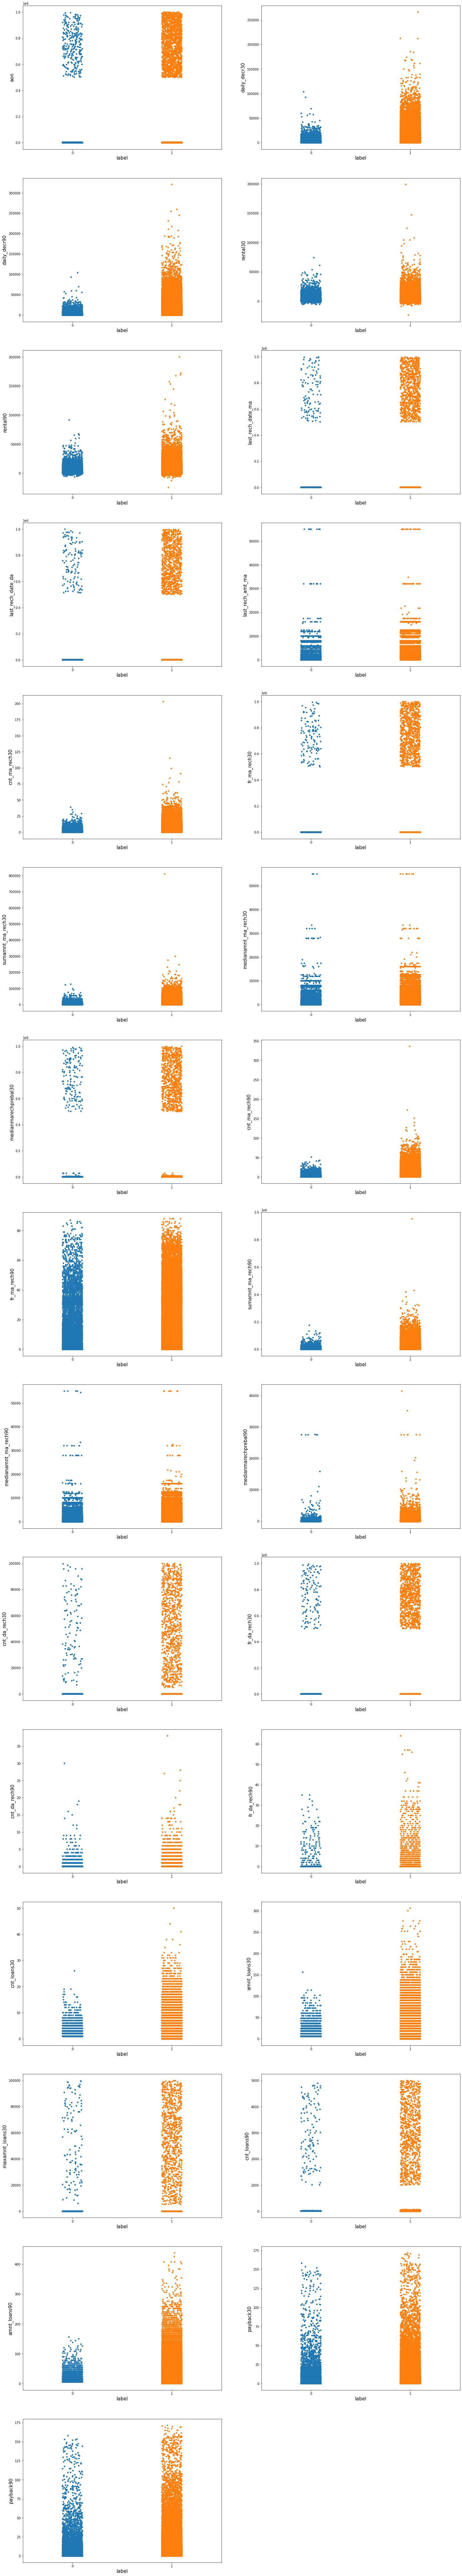

In [21]:
# Strip-plots of the continuous data columns with respect to label.
plt.figure(figsize=(25,150))
plotnumber=1
for column in cont_features:
    if plotnumber<=30:
        ax= plt.subplot(15,2,plotnumber)
        sns.stripplot(x='label',y=column,data=df)
        plt.xlabel('label',fontsize=15)
        plt.ylabel(column,fontsize=15)
    plotnumber+=1
plt.show()

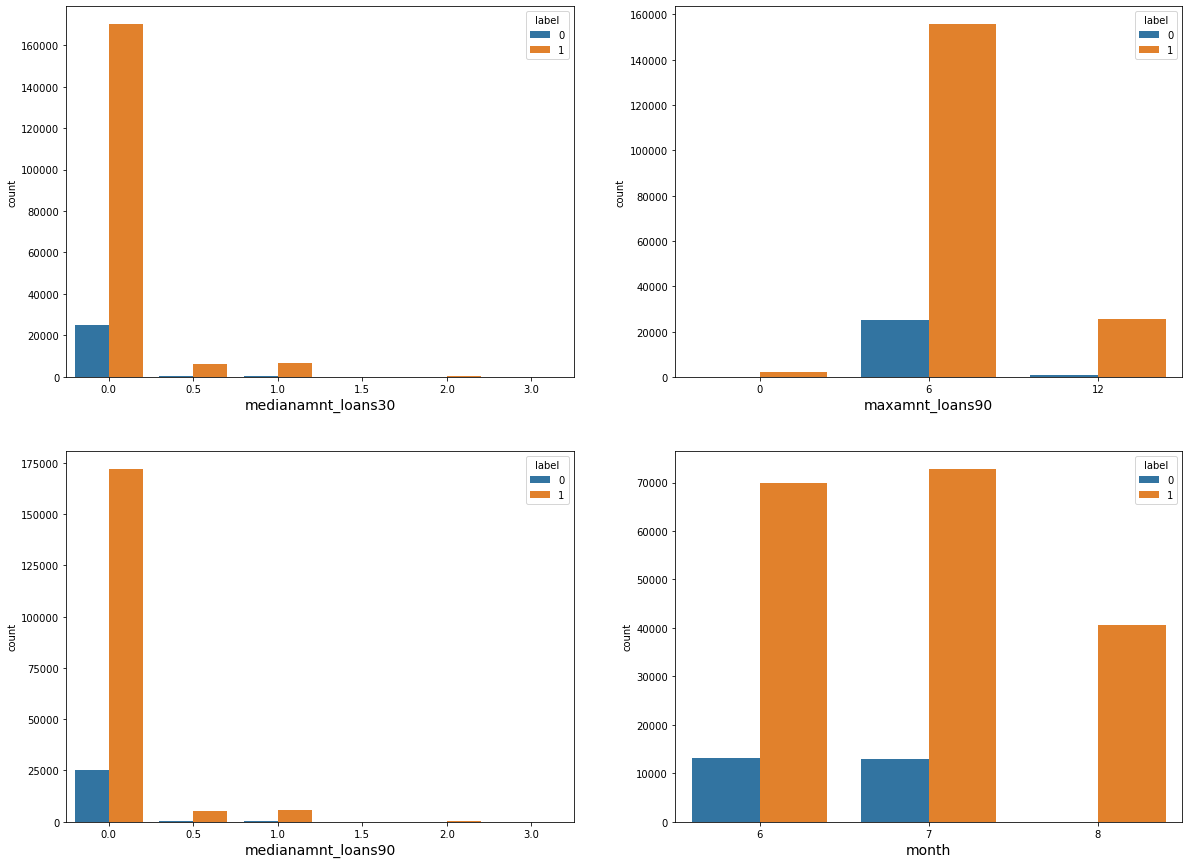

In [22]:
# Count-plots of the columns with categorical data with color coding of the label.
plt.figure(figsize=(20,15))
plotnumber=1
for column in cat_features:
    if plotnumber<=4:
        ax= plt.subplot(2,2,plotnumber)
        sns.countplot(df[column],hue=df['label'])
        plt.xlabel(column,fontsize=14)
    plotnumber+=1
plt.show()

In [23]:
# Let's see the correlation of features with label in absolute-value terms and decreasing order.
corr_mat=df.corr()
corr_with_target= np.abs(corr_mat["label"]).sort_values(ascending= False)
corr_with_target

label                   1.000000
cnt_ma_rech30           0.237120
cnt_ma_rech90           0.236200
sumamnt_ma_rech90       0.205634
sumamnt_ma_rech30       0.202658
amnt_loans90            0.199649
amnt_loans30            0.197123
cnt_loans30             0.196133
daily_decr30            0.168174
daily_decr90            0.166034
month                   0.154707
medianamnt_ma_rech30    0.141248
last_rech_amt_ma        0.131558
medianamnt_ma_rech90    0.120594
fr_ma_rech90            0.084205
maxamnt_loans90         0.084064
rental90                0.075339
rental30                0.057886
payback90               0.049050
payback30               0.048213
medianamnt_loans30      0.044521
medianmarechprebal90    0.039228
medianamnt_loans90      0.035681
day                     0.006630
fr_da_rech90            0.005438
medianmarechprebal30    0.004857
cnt_loans90             0.004707
aon                     0.003825
cnt_da_rech30           0.003806
last_rech_date_ma       0.003705
cnt_da_rec

In [24]:
# Get the list of columns having correlation <0.05 with 'label'
drop_list=[]
for i in range(len(corr_with_target)):
    if corr_with_target[i]<0.05:
        drop_list.append(corr_with_target.index[i])
drop_list

['payback90',
 'payback30',
 'medianamnt_loans30',
 'medianmarechprebal90',
 'medianamnt_loans90',
 'day',
 'fr_da_rech90',
 'medianmarechprebal30',
 'cnt_loans90',
 'aon',
 'cnt_da_rech30',
 'last_rech_date_ma',
 'cnt_da_rech90',
 'last_rech_date_da',
 'fr_ma_rech30',
 'maxamnt_loans30',
 'fr_da_rech30']

In [25]:
# drop the columns.
df.drop(columns=drop_list,inplace=True)

<AxesSubplot:>

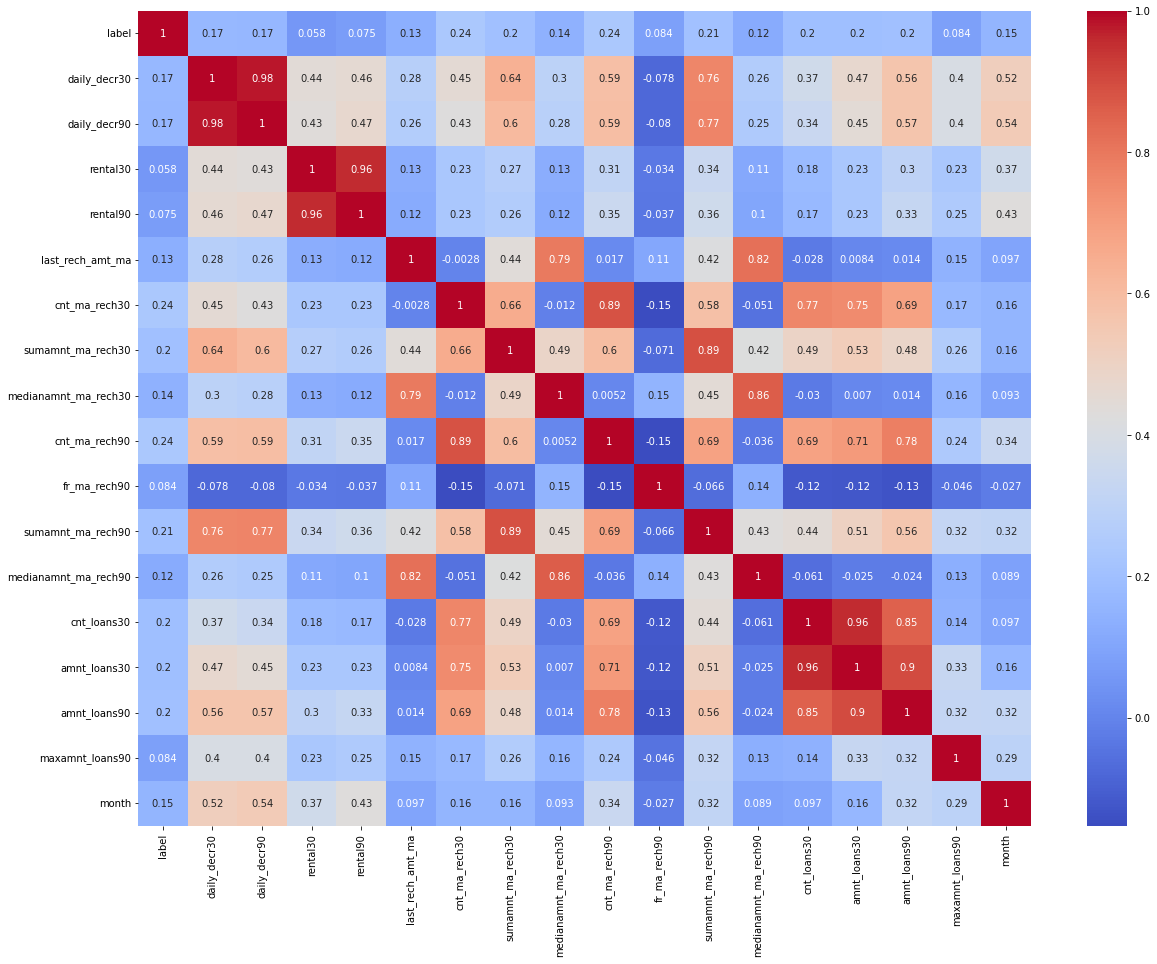

In [26]:
# Let's see the correlation heat-map.
corr_mat=df.corr()
plt.figure(figsize=(20,15))
sns.heatmap(corr_mat, annot=True, cmap="coolwarm")

# 'daily_decr30' and 'daily_decr90' have multicollinearity issue.
# 'rental30' and 'rental90' have multicollinearity issue.
# 'amnt_loans30' and 'amnt_loans90' have multicollinearity issue.
# 'amnt_loans30' and 'cnt_loans90' have multicollinearity issue.
# 'cnt_ma_rech30' and 'cnt_ma_rech90' might have multicollinearity issue.
# 'medianamnt_ma_rech30' and 'medianamnt_ma_rech90' might have multicollinearity issue.
# 'sumamnt_ma_rech30' and 'sumamnt_ma_rech90' might have multicollinearity issue.

In [27]:
# Let's check the vif scores.

# Separating the features and label.
X= df.drop(columns=['label'])
y= df['label']

# applying standard scaler on the features and scaling them.
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
X_scaled= scaler.fit_transform(X)

# checking the variance-inflation-factor among our features.
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["vif"]=[variance_inflation_factor(X_scaled,i) for i in range(X_scaled.shape[1])]
vif["Features"]= X.columns
print(vif)

          vif              Features
0   29.230267          daily_decr30
1   32.055149          daily_decr90
2   13.218987              rental30
3   14.106014              rental90
4    3.411403      last_rech_amt_ma
5   14.977954         cnt_ma_rech30
6   12.727251     sumamnt_ma_rech30
7    5.066614  medianamnt_ma_rech30
8   16.378333         cnt_ma_rech90
9    1.059913          fr_ma_rech90
10  15.165421     sumamnt_ma_rech90
11   5.482834  medianamnt_ma_rech90
12  23.259967           cnt_loans30
13  29.308025          amnt_loans30
14  10.815912          amnt_loans90
15   1.952122       maxamnt_loans90
16   1.733771                 month


In [28]:
# Let's see the correlation of features with label in absolute-value terms and decreasing order.
corr_mat=df.corr()
corr_with_target= np.abs(corr_mat["label"]).sort_values(ascending= False)
corr_with_target

label                   1.000000
cnt_ma_rech30           0.237120
cnt_ma_rech90           0.236200
sumamnt_ma_rech90       0.205634
sumamnt_ma_rech30       0.202658
amnt_loans90            0.199649
amnt_loans30            0.197123
cnt_loans30             0.196133
daily_decr30            0.168174
daily_decr90            0.166034
month                   0.154707
medianamnt_ma_rech30    0.141248
last_rech_amt_ma        0.131558
medianamnt_ma_rech90    0.120594
fr_ma_rech90            0.084205
maxamnt_loans90         0.084064
rental90                0.075339
rental30                0.057886
Name: label, dtype: float64

In [29]:
# drop the columns having multi-collinearity issue.
df.drop(columns=['daily_decr90','rental30','cnt_ma_rech90','sumamnt_ma_rech30','medianamnt_ma_rech90','amnt_loans30',
                 'cnt_loans30'],inplace=True)

In [30]:
# Now let's check the vif scores again.

# Separating the features and label.
X= df.drop(columns=['label'])
y= df['label']

# applying standard scaler on the features and scaling them.
scaler= StandardScaler()
X_scaled= scaler.fit_transform(X)

# checking the variance-inflation-factor among our features.
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["vif"]=[variance_inflation_factor(X_scaled,i) for i in range(X_scaled.shape[1])]
vif["Features"]= X.columns
print(vif)

# No multicollinearity issues can be seen.

        vif              Features
0  3.301530          daily_decr30
1  1.367982              rental90
2  2.779258      last_rech_amt_ma
3  2.377434         cnt_ma_rech30
4  3.028557  medianamnt_ma_rech30
5  1.054324          fr_ma_rech90
6  3.891353     sumamnt_ma_rech90
7  2.374933          amnt_loans90
8  1.245317       maxamnt_loans90
9  1.529222                 month


In [31]:
# making lists of current features according to categorical and continuous type. 
cont_features=[]
cat_features=[]
for i in df.columns:
    if df[i].dtype=='O':
        if len(df[i].unique())<=25:
            cat_features.append(i)
        else:
            cont_features.append(i)
    elif df[i].dtype=='int64':
        if len(df[i].unique())<=25:
            cat_features.append(i)
        else:
            cont_features.append(i)
    elif df[i].dtype=='float64':
        if len(df[i].unique())<=25:
            cat_features.append(i)
        else:
            cont_features.append(i)
    else:
        print(i)

In [33]:
# Check skewness of the continuous data columns.
df[cont_features].skew()

# very high skewness can be seen.

daily_decr30            3.945997
rental90                4.437471
last_rech_amt_ma        3.781206
cnt_ma_rech30           3.283935
medianamnt_ma_rech30    3.512361
fr_ma_rech90            2.285206
sumamnt_ma_rech90       4.897896
amnt_loans90            3.149830
dtype: float64

In [34]:
# make a list of column names on which power-transformation is to be applied.
power_transform_columns= ['last_rech_amt_ma','cnt_ma_rech30','medianamnt_ma_rech30' ,'fr_ma_rech90','amnt_loans90']

In [35]:
# make a list of column names on which cube-root-transformation is to be applied.
cbrt_transform_columns= ['daily_decr30','rental90' ,'sumamnt_ma_rech90']

In [36]:
# Data transformation.

from sklearn.preprocessing import PowerTransformer
pt= PowerTransformer(method="yeo-johnson")

def power_transform(column):
    df[column]= pt.fit_transform(df[[column]])
    
def cube_root_transform(column):
    df[column]= np.cbrt(df[column])

for i in power_transform_columns:
    power_transform(i)
    
for i in cbrt_transform_columns:
    cube_root_transform(i)
    
df[cont_features].skew()

daily_decr30            0.538027
rental90                0.173255
last_rech_amt_ma       -0.060722
cnt_ma_rech30          -0.000146
medianamnt_ma_rech30   -0.189169
fr_ma_rech90            0.142864
sumamnt_ma_rech90      -0.016310
amnt_loans90           -0.008978
dtype: float64

In [37]:
# Separating the features and label.
X= df.drop(columns=['label'])
y= df['label']

In [38]:
# applying standard scaler on the features and scaling them.
scaler= StandardScaler()
X_scaled= scaler.fit_transform(X)

In [39]:
# Defining a function that takes the model and train-test data and returns the predictions.
def get_score(model,train_x,test_x,train_y,test_y):
    ths_hold=0.5
    model.fit(train_x, train_y)
    y_pred_proba= model.predict_proba(test_x)
    pred_y = np.where(y_pred_proba[:,1]>=ths_hold,1,0)
    return pred_y

In [40]:
# Since our target variable is imbalanced hence using SMOTE oversampling technique.
from imblearn.over_sampling import SMOTE
over_sample= SMOTE(0.55,random_state=5)

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier

lr= LogisticRegression()
rf= RandomForestClassifier()
ada_clf = AdaBoostClassifier()
xgb_clf= xgb.XGBClassifier()
knr= KNeighborsClassifier()

models = [lr,rf,ada_clf,xgb_clf,knr]

scores=[[],[],[],[]]
metrics=['Accuracy','Precision','Recall','ROC-AUC']
x_train,x_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.25,random_state=1)
x_train_ns,y_train_ns= over_sample.fit_resample(x_train,y_train)
for model in models:
    y_pred= get_score(model,x_train_ns,x_test,y_train_ns,y_test)
    scores[0].append(round(accuracy_score(y_test,y_pred),2))
    scores[1].append(round(precision_score(y_test,y_pred,pos_label=0),2))
    scores[2].append(round(recall_score(y_test,y_pred,pos_label=0),2))
    scores[3].append(round(roc_auc_score(y_test,y_pred),2))
        
results= pd.DataFrame(scores,columns=['Logistic Regression','Random-Forests Classifier','Adaboost Classifier','XGBoost Classifier'
                                       ,'K-Neighbors Classifier'],
                               index=metrics)
results

,Logistic Regression,Random-Forests Classifier,Adaboost Classifier,XGBoost Classifier,K-Neighbors Classifier
Accuracy,0.82,0.90,0.87,0.90,0.84
Precision,0.37,0.61,0.48,0.61,0.42
Recall,0.61,0.55,0.67,0.63,0.66
ROC-AUC,0.73,0.75,0.79,0.78,0.76


In [42]:
scores=[[],[],[],[]]
x_train,x_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.25,random_state=2)
x_train_ns,y_train_ns= over_sample.fit_resample(x_train,y_train)
for model in models:
    y_pred= get_score(model,x_train_ns,x_test,y_train_ns,y_test)
    scores[0].append(round(accuracy_score(y_test,y_pred),2))
    scores[1].append(round(precision_score(y_test,y_pred,pos_label=0),2))
    scores[2].append(round(recall_score(y_test,y_pred,pos_label=0),2))
    scores[3].append(round(roc_auc_score(y_test,y_pred),2))
        
results= pd.DataFrame(scores,columns=['Logistic Regression','Random-Forests Classifier','Adaboost Classifier','XGBoost Classifier'
                                       ,'K-Neighbors Classifier'],
                               index=metrics)
results

,Logistic Regression,Random-Forests Classifier,Adaboost Classifier,XGBoost Classifier,K-Neighbors Classifier
Accuracy,0.82,0.90,0.87,0.91,0.85
Precision,0.37,0.61,0.48,0.62,0.42
Recall,0.61,0.55,0.68,0.62,0.66
ROC-AUC,0.73,0.75,0.79,0.78,0.76


In [48]:
#Hyperparameter tuning of XGBoost Classifier model using GridSearchCV.
x_train,x_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.25,random_state=2,stratify=y)
params= {"n_estimators": [100,250,500,1000],
         "max_depth":[5,7,9,13,15],       
         "learning_rate":[0.01,0.1,1]
         }
grd_xgb= GridSearchCV(xgb_clf, param_grid=params,cv=5,n_jobs=-1,scoring=make_scorer(recall_score))
grd_xgb.fit(x_train,y_train)
print("Best Parameters:",grd_xgb.best_params_)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 250}


In [51]:
# Performance of the tuned XGBoost model on a train-test split.
x_train,x_test,y_train,y_test = train_test_split(X_scaled,y,test_size=0.25,random_state=2,stratify=y)
xgb_tuned = xgb.XGBClassifier(learning_rate=0.1,max_depth=7,n_estimators=250)
x_train_ns,y_train_ns=over_sample.fit_resample(x_train,y_train)
xgb_tuned.fit(x_train_ns, y_train_ns)
    
y_pred= xgb_tuned.predict(x_test)
accuracy_test = accuracy_score(y_test,y_pred)
print("Testing Score:",round(accuracy_test,2))
print("Precision for 1:",round(precision_score(y_test,y_pred,pos_label=1),2))
print("Recall for 1:",round(recall_score(y_test,y_pred,pos_label=1),2))
print("Precision for 0:",round(precision_score(y_test,y_pred,pos_label=0),2))
print("Recall for 0:",round(recall_score(y_test,y_pred,pos_label=0),2),"\n")
print("ROC_AUC score:",round(roc_auc_score(y_test,y_pred),2),"\n")
print("++++++++++++++ CLASSIFICATION REPORT ++++++++++++++++","\n")
print(classification_report(y_test,y_pred,digits=2))

print("++++++++++++++ CONFUSION MATRIX ++++++++++++++++")
print("\n",confusion_matrix(y_test,y_pred),"\n")

Testing Score: 0.9
Precision for 1: 0.95
Recall for 1: 0.94
Precision for 0: 0.62
Recall for 0: 0.63 

ROC_AUC score: 0.79 

++++++++++++++ CLASSIFICATION REPORT ++++++++++++++++ 

              precision    recall  f1-score   support

           0       0.62      0.63      0.62      6533
           1       0.95      0.94      0.95     45858

    accuracy                           0.90     52391
   macro avg       0.78      0.79      0.78     52391
weighted avg       0.91      0.90      0.91     52391

++++++++++++++ CONFUSION MATRIX ++++++++++++++++

 [[ 4095  2438]
 [ 2547 43311]] 



In [62]:
# defining a function that takes train, test data and the model and returns the accuracy score.
def cv_accuracy(train, test, model):
    x_train = train.drop(['label'],axis=1)
    y_train = train.label
    x_test = test.drop(['label'],axis=1)
    y_test = test.label
    x_train_ns,y_train_ns= over_sample.fit_resample(x_train,y_train)
    model.fit(x_train_ns, y_train_ns)
    y_pred= model.predict(x_test)
    score = accuracy_score(y_test,y_pred)
    return score

# defining a function that takes train, test data and the model and returns the precision score.
def cv_precision(train, test, model):
    x_train = train.drop(['label'],axis=1)
    y_train = train.label
    x_test = test.drop(['label'],axis=1)
    y_test = test.label
    x_train_ns,y_train_ns= over_sample.fit_resample(x_train,y_train)
    model.fit(x_train_ns, y_train_ns)
    y_pred= model.predict(x_test)
    score = precision_score(y_test,y_pred,pos_label=0)
    return score

# defining a function that takes train, test data and the model and returns the recall score.
def cv_recall(train, test, model):
    x_train = train.drop(['label'],axis=1)
    y_train = train.label
    x_test = test.drop(['label'],axis=1)
    y_test = test.label
    x_train_ns,y_train_ns= over_sample.fit_resample(x_train,y_train)
    model.fit(x_train_ns, y_train_ns)
    y_pred= model.predict(x_test)
    score = recall_score(y_test,y_pred,pos_label=0)
    return score

In [63]:
# cross-validating the accuracy of XGBoost model.
for i in [5,10]:
    skf= StratifiedKFold(n_splits=i)
    fold_no = 1
    scores=[]
    for train_index,test_index in skf.split(X_scaled, y):
        train = df.iloc[train_index,:]
        test = df.iloc[test_index,:]
        get_score= cv_accuracy(train, test,xgb_tuned)
        scores.append(get_score)
        fold_no += 1
    avg_score= sum(scores)/len(scores)
    print(f'For {i}-Fold the accuracy is {avg_score}')

For 5-Fold the accuracy is 0.9074689227893588
For 10-Fold the accuracy is 0.9077599996313086


In [64]:
# cross-validating the precision of XGBoost model.
for i in [5,10]:
    skf= StratifiedKFold(n_splits=i)
    fold_no = 1
    scores=[]
    for train_index,test_index in skf.split(X_scaled, y):
        train = df.iloc[train_index,:]
        test = df.iloc[test_index,:]
        get_score= cv_precision(train, test,xgb_tuned)
        scores.append(get_score)
        fold_no += 1
    avg_score= sum(scores)/len(scores)
    print(f'For {i}-Fold the precision is {avg_score}')

For 5-Fold the precision is 0.6387562396418625
For 10-Fold the precision is 0.6396691907979608


In [65]:
# cross-validating the recall of XGBoost model.
for i in [5,10]:
    skf= StratifiedKFold(n_splits=i)
    fold_no = 1
    scores=[]
    for train_index,test_index in skf.split(X_scaled, y):
        train = df.iloc[train_index,:]
        test = df.iloc[test_index,:]
        get_score= cv_recall(train, test,xgb_tuned)
        scores.append(get_score)
        fold_no += 1
    avg_score= sum(scores)/len(scores)
    print(f'For {i}-Fold the recall is {avg_score}')

For 5-Fold the recall is 0.5939618181113973
For 10-Fold the recall is 0.5962584669495791


In [68]:
# Saving the model using pickle.
import pickle 
Micro_Credit= "Micro-Credit_Defaulter_model.pickle"
pickle.dump(xgb_tuned, open(Micro_Credit,'wb'))